## Alternative aproach to MGA using euclidean distance

In [1]:
import pypsa
import pandas as pd

In this section a series of coppies of seperate disconected busses/networks is generated. They are all in the same PyPSA model, but will not influence each other

### Network 1
This is a simple network with a limited number of variables

In [2]:
# Creating a networks and adding a MGA class to the network object
network1 = pypsa.Network()
class MGA:
    pass
network1.MGA = MGA
network1.MGA.nr_of_networks = 5

# Setting number of snapshots to simulate
network1.set_snapshots(range(1))
# Looping over the number of networks to be created,
# and altering the bus name and the generator names.
# The last number in the generator name indicates which instance
# of the networks they belong to
for i in range(network1.MGA.nr_of_networks):
    
    # Add a bus to the network.
    bus_nr = 'bus'+str(i+1)
    network1.add("Bus",bus_nr,x=i,y=i%2)

    # Add a coal power plant to the bus.
    network1.add("Generator",'coal'+str(i+1),bus=bus_nr,
           type = 'coal',
           committable=True,
           p_min_pu=0.2,
           marginal_cost=55,
           capital_cost = 49000,
           p_nom_extendable=True,
           p_nom_max=4000)

    # Add a gas power plant to the bus.
    network1.add("Generator",'gas'+str(i+1),bus=bus_nr,
           type = 'gas',
           committable=True,
           marginal_cost=20,
           capital_cost = 75000,
           p_min_pu=0,
           p_nom_extendable=True,
           p_nom_max=2000)
    # Add a gas power plant to the bus.
    network1.add("Generator",'bio'+str(i+1),bus=bus_nr,
           type = 'bio',
           committable=True,
           marginal_cost=75,
           capital_cost = 37500,
           p_min_pu=0,
           p_nom_extendable=True,
           p_nom_max=3000)
    # Add load to the bus.
    network1.add("Load",'load'+str(i+1),bus=bus_nr,p_set=[4000])

(<matplotlib.collections.PathCollection at 0x2900c75e2e8>,)

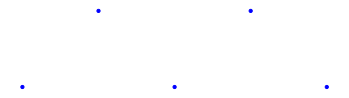

In [3]:
network1.plot()

### Network 2
A much more complex network, simulating an entire year of production with hourly data

In [4]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
# Create network
network2 = pypsa.Network()
class MGA:
    pass
network2.MGA = MGA
network2.MGA.nr_of_networks = 5

# Import of data
hours_in_2018=pd.date_range('2017-06-01T00:00Z','2017-07-01T00:00Z',freq='H') #'2017-12-31T23:00Z'
network2.set_snapshots(hours_in_2018)
# wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind=df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network2.snapshots]]
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
# solar data
df_solar = pd.read_csv('data/pv_optimal.csv',sep=';',index_col=0)
CF_solar=df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network2.snapshots]]
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
# OCGT data
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el

# electricity demand data
df_elec = pd.read_csv('data/Total Load - Day Ahead _ Actual_DK_201701010000-201801010000.csv',sep=',',index_col=0) # in MWh
df_elec = df_elec[:network2.snapshots.size]

# As with network1, i loop over the number of networks to be generated, 
# altering the index on the names
for i in range(network2.MGA.nr_of_networks):

    # Add a electricity bus to the network
    bus_nr = 'bus'+str(i+1)
    network2.add("Bus",bus_nr)

    # add load to the bus
    network2.add("Load","load"+str(i+1), 
                bus=bus_nr, 
                p_set=df_elec['Actual Total Load [MW] - Denmark (DK)'].tolist())
    
    # add onshore wind generator
    network2.add("Generator",
                "onshorewind"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="onshorewind",
                #p_nom_max=1000,
                capital_cost = capital_cost_onshorewind,
                marginal_cost = 0,
                p_max_pu = CF_wind)

    # add solar PV generator
    network2.add("Generator",
                "solar"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="solar",
                #p_nom_max=1000,
                capital_cost = capital_cost_solar,
                marginal_cost = 0,
                p_max_pu = CF_solar)


    network2.add("Generator",
                "OCGT"+str(i+1),
                bus=bus_nr,
                p_nom_extendable=True,
                #carrier="gas",
                p_nom_max=4000,
                capital_cost = capital_cost_OCGT,
                marginal_cost = marginal_cost_OCGT
               )

As with the regular MGA aproach the network is first solved without the new objective function

In [5]:
    # Initial solution of network, with non MGA objective function 
    network = network1
    network.lopf(network.snapshots,solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.pf:Slack bus for sub-network 3 is bus4
INFO:pypsa.pf:Slack bus for sub-network 4 is bus5
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal1', 'gas1', 'bio1', 'coal2', 'gas2', 'bio2', 'coal3', 'gas3',
       'bio3', 'coal4', 'gas4', 'bio4', 'coal5', 'gas5', 'bio5'],
      dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x36
  Lower bound: 808900000.0
  Upper bound: 808900000.0
  Number of objectives: 1
  Number of constraints: 41
  Number of variables: 36
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 36
  Number of nonzeros: 71
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optim

('ok', 'optimal')

The initial solution will alway contain a set of identical networks. The last number in the generators describe which network they belong to

In [6]:
network.generators_t.p

,coal1,gas1,bio1,coal2,gas2,bio2,coal3,gas3,bio3,coal4,gas4,bio4,coal5,gas5,bio5
0,1000.0,0.0,3000.0,1000.0,0.0,3000.0,1000.0,0.0,3000.0,1000.0,0.0,3000.0,1000.0,0.0,3000.0


In [7]:
    # Saving the value of the old objective function.
    old_objective_value = network.model.objective()
    old_objective_value/network.MGA.nr_of_networks/1000000

161.78

## Defining an alternative objective function 

In this alternative aproach, the MGA objective function seeks to maximize the distance between a number $N$ of networks with $K$ variables. The distance between the networks can be described with the squared euqlidian distance for an $n$ dimentional vector. 

$ d = \sum_{i=1}^n{(x_{i}-x_{i})^2} $

By summing the distance from each network to all other networks, an expression describing the distinction between the networks is found. The following objective function will try to maximize the distance between all networks:

$N$ : Number of independent networks 

$K$ : Number of variables in each network

$x$ : 2D vector containing all variables. 1st index specifies the variable and 2nd index specifies the network

$ p= - \frac{1}{2}  \sum_i^N{\sum_j^N{\sum_k^K{(x_{k,i}-x_{k,j})^2}}}  $ 

The drawback is that the objective function is now a square function, increasing computation time, however gurobi is capable of handeling it, at least for smaller energy systems

In [44]:
def extra_functionality(network, snapshots,  MGA_slack = 0.05):
    # Defining exstra functionality, that updates the objective function of the network
    # Default value for MGA_slack is 0.05 if nothing else is specified 
    import pyomo.environ as pyomo_env

    # Number of networks
    #N = int(list(network.generators_t.p.columns)[-1][-1]) 
    N = network.MGA.nr_of_networks
    # Generating a list of variables sorted after their variable index and network number
    # First index: Variable nr
    # Second index: Network number    
    gen_p_list = [[] for i in range(N)]
    for gen_p in network.model.generator_p:
        gen_p_network_idx = int(gen_p[0][-1])-1
        gen_p_list[gen_p_network_idx].append(gen_p)
    # Number of variables in each network
    K = len(gen_p_list[0]) 

    # Creating the MGA objective function
    MGA_objective = 0
    for i in range(N):
        for j in range(N):
            for k in range(K):
                if i < j:
                    gen_p1 = network.model.generator_p[gen_p_list[i][k]]
                    gen_p2 = network.model.generator_p[gen_p_list[j][k]]
                    MGA_objective += (gen_p1**2 + gen_p2**2 - 2*gen_p1*gen_p2 )
    # Changing sign of objective function to make it a minimization problem
    MGA_objective = - MGA_objective 
    #print (MGA_objective)

    # Adding new MGA objective function to network 
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    #network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
    #                                      (1 + MGA_slack) * old_objective_value)


    constraint0 = 0
    constraint1 = 0
    constraint2 = 0
    constraint3 = 0
    constraint4 = 0
    for i in range(3):
        constraint0 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[0][i]]
        constraint0 += network.generators.ix[i,'capital_cost']*network.model.generator_p_nom[gen_p_list[0][i]]
        constraint1 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[1][i]]
        constraint1 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[1][i]]
        constraint2 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[2][i]]
        constraint2 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[2][i]]
        constraint3 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[3][i]]
        constraint3 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[3][i]]
        constraint4 += network.generators.ix[i,'marginal_cost']*network.model.generator_p[gen_p_list[4][i]]
        constraint4 += network.generators.ix[i,'capital_cost']*network.model.generator_p[gen_p_list[4][i]]
    
    network.model.mga_constraint0 = pyomo_env.Constraint(expr = constraint0<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint1 = pyomo_env.Constraint(expr = constraint1<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint2 = pyomo_env.Constraint(expr = constraint2<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint3 = pyomo_env.Constraint(expr = constraint3<= (1 + MGA_slack) * old_objective_value/5)
    network.model.mga_constraint4 = pyomo_env.Constraint(expr = constraint4<= (1 + MGA_slack) * old_objective_value/5)

In [45]:
#print(network.model.objective.expr)

print(network.model.generator_p)

generator_p


### Solving network with MGA objective function

In [46]:
MGA_slack = 0.1
#Solve network with updated objective function
network.lopf(network.snapshots,\
             solver_name='gurobi',\
             extra_functionality=lambda network,\
             snapshots: extra_functionality(network, snapshots, MGA_slack),
             solver_options = {'psdtol':100,'presolve':-1}) 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus1
INFO:pypsa.pf:Slack bus for sub-network 1 is bus2
INFO:pypsa.pf:Slack bus for sub-network 2 is bus3
INFO:pypsa.pf:Slack bus for sub-network 3 is bus4
INFO:pypsa.pf:Slack bus for sub-network 4 is bus5
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal1', 'gas1', 'bio1', 'coal2', 'gas2', 'bio2', 'coal3', 'gas3',
       'bio3', 'coal4', 'gas4', 'bio4', 'coal5', 'gas5', 'bio5'],
      dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
C:\Users\Tim\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Tim\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: Depreca

KeyError: "Index '('coal1', 0)' is not valid for indexed component 'generator_p_nom'"

In [24]:
network.generators_t.p

,coal1,gas1,bio1,coal2,gas2,bio2,coal3,gas3,bio3,coal4,gas4,bio4,coal5,gas5,bio5
0,2409.233449,1.297806e-14,1590.766551,1704.320765,216.114237,2079.564998,1704.320651,216.114272,2079.565077,1704.320875,216.114204,2079.564921,376.930483,623.069517,3000.0


### Plotting funciton 

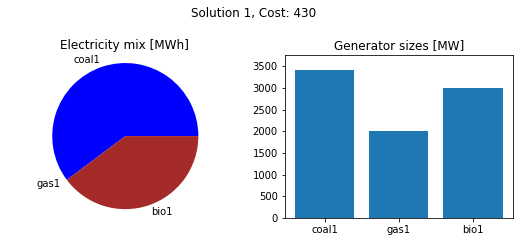

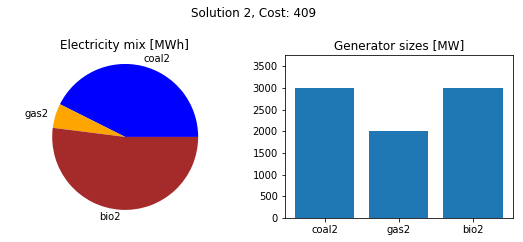

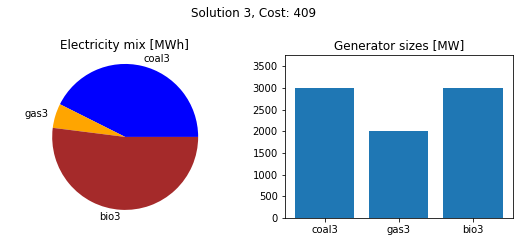

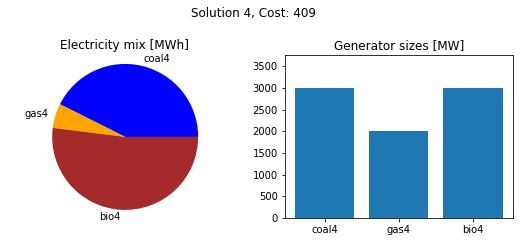

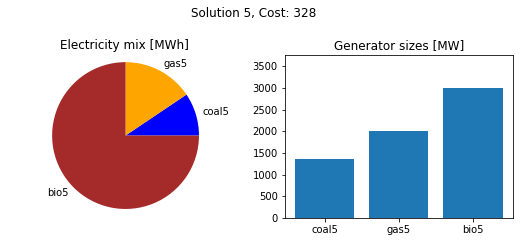

In [25]:
import matplotlib.pyplot as plt
labels = network.generators.index.tolist()
productions = [] # Production in MWh per technology
for generator in network.generators.index.tolist():
    productions.append(network.generators_t.p[generator].sum())

sizes=network.generators['p_nom_opt'] # Plant sizes in MW

generator_cost = network.generators['capital_cost']*sizes+productions*network.generators['marginal_cost']
network_cost = [] # Total cost for one year of opperation
for i in range(network.MGA.nr_of_networks):
    network_cost.append( int(sum(generator_cost[i*3:i*3+3])/1000000))
    
for idx in range(network.MGA.nr_of_networks):
    colors=['blue', 'orange', 'brown']
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=False)
    #plt.figure(idx+1)
    
    fig.suptitle('Solution '+str(idx+1) + ', Cost: ' + str(network_cost[idx]),y=1.1)
    
    axs[0].pie(productions[3*idx:3*idx+3], 
            colors=colors, 
            labels=labels[3*idx:3*idx+3], 
            wedgeprops={'linewidth':0})
    axs[0].axis('equal')
    axs[0].set_title('Electricity mix [MWh]', y=1)
    
    axs[1].bar([0,1,2],
               sizes[3*idx:3*idx+3], 
               width=0.8,
               bottom=-1)
    axs[1].set_ylim(0,max(sizes)*1.1)
    axs[1].set_xticks([0,1,2])
    axs[1].set_xticklabels(labels[3*idx:3*idx+3])
    axs[1].set_title('Generator sizes [MW]', y=1)

In [26]:
network.generators_t.p

,coal1,gas1,bio1,coal2,gas2,bio2,coal3,gas3,bio3,coal4,gas4,bio4,coal5,gas5,bio5
0,2409.233449,1.297806e-14,1590.766551,1704.320765,216.114237,2079.564998,1704.320651,216.114272,2079.565077,1704.320875,216.114204,2079.564921,376.930483,623.069517,3000.0


In [27]:
network.generators[network.generators['type']=='bio']

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,initial_status,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
bio1,bus1,PQ,bio,0.0,True,0.0,3000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,3000.0
bio2,bus2,PQ,bio,0.0,True,0.0,3000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,3000.0
bio3,bus3,PQ,bio,0.0,True,0.0,3000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,3000.0
bio4,bus4,PQ,bio,0.0,True,0.0,3000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,3000.0
bio5,bus5,PQ,bio,0.0,True,0.0,3000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,3000.0


In [28]:
(1+MGA_slack)*old_objective_value/5000000

177.95800000000003

In [39]:
print(network.model.mga_constraint0.expr)
print(network.model.objective.expr)

55.0*generator_p[coal1,0] + 49000.0*generator_p[coal1,0] + 20.0*generator_p[gas1,0] + 75000.0*generator_p[gas1,0] + 75.0*generator_p[bio1,0] + 37500.0*generator_p[bio1,0]  <=  177958000.00000003
55.0*generator_p[coal1,0] + 20.0*generator_p[gas1,0] + 75.0*generator_p[bio1,0] + 55.0*generator_p[coal2,0] + 20.0*generator_p[gas2,0] + 75.0*generator_p[bio2,0] + 55.0*generator_p[coal3,0] + 20.0*generator_p[gas3,0] + 75.0*generator_p[bio3,0] + 55.0*generator_p[coal4,0] + 20.0*generator_p[gas4,0] + 75.0*generator_p[bio4,0] + 55.0*generator_p[coal5,0] + 20.0*generator_p[gas5,0] + 75.0*generator_p[bio5,0] + 49000.0*generator_p_nom[coal1] + 75000.0*generator_p_nom[gas1] + 37500.0*generator_p_nom[bio1] + 49000.0*generator_p_nom[coal2] + 75000.0*generator_p_nom[gas2] + 37500.0*generator_p_nom[bio2] + 49000.0*generator_p_nom[coal3] + 75000.0*generator_p_nom[gas3] + 37500.0*generator_p_nom[bio3] + 49000.0*generator_p_nom[coal4] + 75000.0*generator_p_nom[gas4] + 37500.0*generator_p_nom[bio4] + 49000.0

In [43]:
print(network.model.generator_p_nom)

generator_p_nom


In [49]:
network.generators['p_nom_opt']

coal1    3427.946693
gas1     2000.000000
bio1     3000.000000
coal2    3003.677437
gas2     2000.000000
bio2     3000.000000
coal3    3003.677135
gas3     2000.000000
bio3     3000.000000
coal4    3003.677591
gas4     2000.000000
bio4     3000.000000
coal5    1350.554709
gas5     2000.000000
bio5     3000.000000
Name: p_nom_opt, dtype: float64